
# Overview of multiclass training meta-estimators

In this example, we discuss the problem of classification when the target
variable is composed of more than two classes. This is called multiclass
classification.

In scikit-learn, all estimators support multiclass classification out of the
box: the most sensible strategy was implemented for the end-user. The
:mod:`sklearn.multiclass` module implements various strategies that one can use
for experimenting or developing third-party estimators that only support binary
classification.

:mod:`sklearn.multiclass` includes OvO/OvR strategies used to train a
multiclass classifier by fitting a set of binary classifiers (the
:class:`~sklearn.multiclass.OneVsOneClassifier` and
:class:`~sklearn.multiclass.OneVsRestClassifier` meta-estimators). This example
will review them.


## The Yeast UCI dataset

In this example, we use a UCI dataset [1]_, generally referred as the Yeast
dataset. We use the :func:`sklearn.datasets.fetch_openml` function to load
the dataset from OpenML.



In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=181, as_frame=True, return_X_y=True)

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


To know the type of data science problem we are dealing with, we can check
the target for which we want to build a predictive model.



In [3]:
y.value_counts().sort_index()

class_protein_localization
CYT    463
ERL      5
EXC     35
ME1     44
ME2     51
ME3    163
MIT    244
NUC    429
POX     20
VAC     30
Name: count, dtype: int64

We see that the target is discrete and composed of 10 classes. We therefore
deal with a multiclass classification problem.

## Strategies comparison

In the following experiment, we use a
:class:`~sklearn.tree.DecisionTreeClassifier` and a
:class:`~sklearn.model_selection.RepeatedStratifiedKFold` cross-validation
with 3 splits and 5 repetitions.

We compare the following strategies:

* :class:~sklearn.tree.DecisionTreeClassifier can handle multiclass
  classification without needing any special adjustments. It works by breaking
  down the training data into smaller subsets and focusing on the most common
  class in each subset. By repeating this process, the model can accurately
  classify input data into multiple different classes.
* :class:`~sklearn.multiclass.OneVsOneClassifier` trains a set of binary
  classifiers where each classifier is trained to distinguish between
  two classes.
* :class:`~sklearn.multiclass.OneVsRestClassifier`: trains a set of binary
  classifiers where each classifier is trained to distinguish between
  one class and the rest of the classes.
* :class:`~sklearn.multiclass.OutputCodeClassifier`: trains a set of binary
  classifiers where each classifier is trained to distinguish between
  a set of classes from the rest of the classes. The set of classes is
  defined by a codebook, which is randomly generated in scikit-learn. This
  method exposes a parameter `code_size` to control the size of the codebook.
  We set it above one since we are not interested in compressing the class
  representation.



### OneVsOneClassifier (OVO) vs. OneVsRestClassifier (OVR)

#### OneVsRestClassifier (OVR)

The OneVsRestClassifier (OVR) strategy involves training a separate classifier for each class, where each classifier is trained to distinguish samples of a single class from samples of all other classes. Mathematically, for $K$ classes, the OVR approach involves training $K$ binary classifiers:

$$
h_k(x) = \begin{cases} 
1 & \text{if } x \text{ belongs to class } k \\
0 & \text{otherwise}
\end{cases}
$$

where $k \in \{1, 2, \dots, K\}$. Each classifier $h_k$ is trained to separate class $k$ from the rest of the classes.

**Advantages:**
- **Simplicity**: Easy to implement and understand.
- **Scalability**: Works well for a large number of classes.

**Disadvantages:**
- **Imbalanced Training Data**: Each classifier is trained on an imbalanced dataset (one class vs. the rest).
- **Overlapping Regions**: Can lead to overlapping decision regions where multiple classifiers predict positive results for a single sample.

#### OneVsOneClassifier (OVO)

The OneVsOneClassifier (OVO) strategy involves training a separate classifier for every pair of classes. For $K$ classes, the OVO approach involves training $\binom{K}{2}$ binary classifiers:

$$
h_{ij}(x) = \begin{cases} 
1 & \text{if } x \text{ belongs to class } i \\
0 & \text{if } x \text{ belongs to class } j 
\end{cases}
$$

where $i, j \in \{1, 2, \dots, K\}$ and $i \neq j$. Each classifier $h_{ij}$ is trained to distinguish between class $i$ and class $j$. During prediction, a voting scheme is employed where each classifier casts a vote for the predicted class, and the class with the most votes is selected.

**Advantages:**
- **Balanced Training Data**: Each classifier is trained on a balanced subset of the data (only the two classes involved).
- **More Binary Decisions**: More classifiers mean more binary decisions, which can lead to more precise boundaries.

**Disadvantages:**
- **Computational Complexity**: Requires training $\binom{K}{2}$ classifiers, which can be computationally expensive for a large number of classes.
- **Storage and Memory**: Increased number of classifiers requires more storage and memory.

#### Mathematical Comparison

- **Number of Classifiers**:
  - OVR: $K$ classifiers
  - OVO: $\binom{K}{2} = \frac{K(K-1)}{2}$ classifiers

- **Training Data**:
  - OVR: Each classifier $h_k$ is trained on the full dataset with an imbalanced label (class $k$ vs. the rest).
  - OVO: Each classifier $h_{ij}$ is trained on only the samples belonging to classes $i$ and $j$, making the training data more balanced.

- **Prediction**:
  - OVR: For a test sample $x$, each classifier $h_k(x)$ outputs a binary decision. The final class is determined by the classifier with the highest confidence score.
  - OVO: For a test sample $x$, each classifier $h_{ij}(x)$ outputs a binary decision. The final class is determined by a majority voting scheme among all pairwise classifiers.

#### Decision Boundaries

- **OVR**: The decision boundaries are influenced by the imbalanced nature of the training data. This can lead to broader, less precise boundaries.
- **OVO**: The decision boundaries are formed by considering only pairs of classes, leading to more localized and precise boundaries.

#### Summary

- **OneVsRestClassifier (OVR)** is simpler and scales better with a large number of classes, but it may suffer from imbalanced training data and overlapping decision regions.
- **OneVsOneClassifier (OVO)** provides more precise decision boundaries by considering pairs of classes, but it requires training a larger number of classifiers, which can be computationally and memory intensive.

Choosing between OVR and OVO depends on the specific requirements of the problem, such as the number of classes, computational resources, and the importance of modeling class interactions accurately.


In [4]:
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.multiclass import (
    OneVsOneClassifier,
    OneVsRestClassifier,
    OutputCodeClassifier,
)
from sklearn.tree import DecisionTreeClassifier

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)

tree = DecisionTreeClassifier(random_state=0)
ovo_tree = OneVsOneClassifier(tree)
ovr_tree = OneVsRestClassifier(tree)
ecoc = OutputCodeClassifier(tree, code_size=2)

cv_results_tree = cross_validate(tree, X, y, cv=cv, n_jobs=2)
cv_results_ovo = cross_validate(ovo_tree, X, y, cv=cv, n_jobs=2)
cv_results_ovr = cross_validate(ovr_tree, X, y, cv=cv, n_jobs=2)
cv_results_ecoc = cross_validate(ecoc, X, y, cv=cv, n_jobs=2)

We can now compare the statistical performance of the different strategies.
We plot the score distribution of the different strategies.



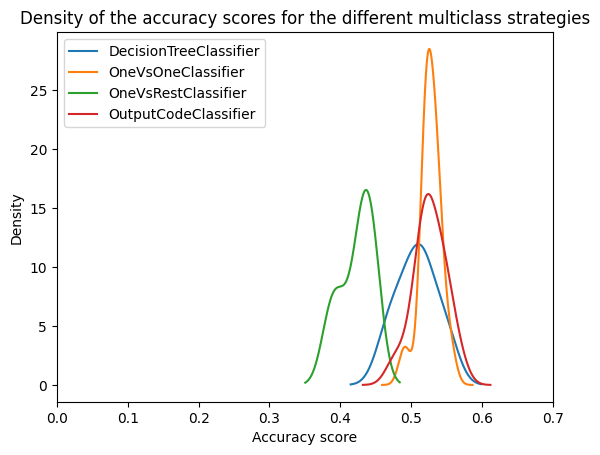

In [5]:
from matplotlib import pyplot as plt

scores = pd.DataFrame(
    {
        "DecisionTreeClassifier": cv_results_tree["test_score"],
        "OneVsOneClassifier": cv_results_ovo["test_score"],
        "OneVsRestClassifier": cv_results_ovr["test_score"],
        "OutputCodeClassifier": cv_results_ecoc["test_score"],
    }
)
ax = scores.plot.kde(legend=True)
ax.set_xlabel("Accuracy score")
ax.set_xlim([0, 0.7])
_ = ax.set_title(
    "Density of the accuracy scores for the different multiclass strategies"
)

At a first glance, we can see that the built-in strategy of the decision
tree classifier is working quite well. One-vs-one and the error-correcting
output code strategies are working even better. However, the
one-vs-rest strategy is not working as well as the other strategies.

Indeed, these results reproduce something reported in the literature
as in [2]_. However, the story is not as simple as it seems.

## The importance of hyperparameters search

It was later shown in [3]_ that the multiclass strategies would show similar
scores if the hyperparameters of the base classifiers are first optimized.

Here we try to reproduce such result by at least optimizing the depth of the
base decision tree.



In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier

# Define the base DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

# Create a OneVsOneClassifier with the base DecisionTreeClassifier
ovo_tree = OneVsOneClassifier(tree)

# Define the parameter grid
param_grid = {"estimator__max_depth": [3, 5, 8, 10], "estimator__criterion": ["gini", "entropy"]}

# Create a GridSearchCV object with the OneVsOneClassifier
tree_optimized = GridSearchCV(ovo_tree, param_grid=param_grid, cv=3)

# Fit the GridSearchCV with training data
tree_optimized.fit(X, y)

# Get the best parameters after fitting
best_params = tree_optimized.best_params_
print("Best parameters found: ", best_params)


Best parameters found:  {'estimator__criterion': 'entropy', 'estimator__max_depth': 3}


In [21]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier

# Define the base DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

# Create a OneVsOneClassifier with the base DecisionTreeClassifier
ovo_tree = OneVsOneClassifier(tree)

# Define the parameter grid
param_grid = {"estimator__max_depth": [3, 5, 8, 10], "estimator__criterion": ["gini", "entropy"]}

# Create a GridSearchCV object with the OneVsOneClassifier
tree_optimized = GridSearchCV(ovo_tree, param_grid=param_grid, cv=3, return_train_score=True)

# Fit the GridSearchCV with training data
tree_optimized.fit(X, y)


results_df = pd.DataFrame(tree_optimized.cv_results_)

# Extract parameter columns and test scores
params_df = results_df['params'].apply(pd.Series)
scores_df = results_df[['mean_test_score', 'std_test_score', 'rank_test_score']]

# Concatenate parameter columns with test scores
final_df = pd.concat([params_df, scores_df], axis=1)

# Display the DataFrame
print(final_df)




  estimator__criterion  estimator__max_depth  mean_test_score  std_test_score  \
0                 gini                     3         0.572091        0.022623   
1                 gini                     5         0.559965        0.008698   
2                 gini                     8         0.534371        0.015462   
3                 gini                    10         0.526291        0.012840   
4              entropy                     3         0.576807        0.013219   
5              entropy                     5         0.568726        0.008643   
6              entropy                     8         0.544476        0.006760   
7              entropy                    10         0.523579        0.006704   

   rank_test_score  
0                2  
1                4  
2                6  
3                7  
4                1  
5                3  
6                5  
7                8  


### OutputCodeClassifier

The `OutputCodeClassifier` is a meta-estimator in scikit-learn that transforms the problem of multi-class classification into multiple binary classification problems, similar to strategies like OneVsOne (OVO) and OneVsRest (OVR). However, it uses a unique approach based on error-correcting codes, which can provide robustness to misclassifications and improve performance in certain scenarios.

#### What it Does

The `OutputCodeClassifier` works by encoding the classes using a code matrix, where each row represents a unique binary code for each class. Each binary classifier is trained to predict a specific bit in the code. During prediction, the binary classifiers' outputs are combined to form a binary code, which is then matched to the closest class code in the code matrix.

#### Parameters

- **estimator**: The base estimator used for binary classification. In the provided example, a `GridSearchCV` object with a `DecisionTreeClassifier` is used.
- **code_size**: The size of the code, which is the number of binary classifiers used. A larger code size can provide more robustness but requires more computation.

#### Mathematical Details

1. **Code Matrix Construction**:
   - Let $C$ be the number of classes and $L$ be the code size.
   - Construct a code matrix $M \in \{-1, 1\}^{C \times L}$, where each row $M_{c}$ represents a unique binary code for class $c$.

2. **Training**:
   - For each binary classifier $j \in \{1, \ldots, L\}$, train the classifier to predict the $j$-th bit of the code $M_{c, j}$.
   - The training set for classifier $j$ is transformed based on the $j$-th column of the code matrix $M$.

3. **Prediction**:
   - For a test sample $x$, each binary classifier predicts a bit, forming a predicted code $\hat{y} \in \{-1, 1\}^L$.
   - Compute the Hamming distance between $\hat{y}$ and each row in the code matrix $M$.
   - Assign the class corresponding to the row in $M$ with the smallest Hamming distance to $\hat{y}$.

#### Advantages

- **Robustness to Misclassifications**: By using a redundant coding scheme, `OutputCodeClassifier` can tolerate some misclassifications among the binary classifiers and still make a correct overall classification.
- **Error-Correcting Properties**: The coding matrix can be designed to have error-correcting properties, providing additional robustness.
- **Flexibility**: Different types of base estimators can be used, and the code size can be adjusted to balance between robustness and computational efficiency.

#### Differences from OVO and OVR

- **OVO (OneVsOneClassifier)**:
  - Trains $\binom{C}{2}$ binary classifiers, each distinguishing between a pair of classes.
  - Combines predictions using a voting scheme.
  - Does not inherently provide robustness to individual classifier errors.

- **OVR (OneVsRestClassifier)**:
  - Trains $C$ binary classifiers, each distinguishing one class from all others.
  - Each classifier's prediction is combined to determine the final class.
  - Simpler and less computationally intensive than OVO but can suffer from imbalanced training data.

- **OutputCodeClassifier**:
  - Uses a code matrix to encode classes and trains $L$ binary classifiers.
  - Combines predictions by matching the predicted code to the closest code in the matrix.
  - Provides robustness through error-correcting codes, which can tolerate some misclassifications.

### Summary

The `OutputCodeClassifier` transforms a multi-class problem into multiple binary classification problems using a code matrix with error-correcting properties. This approach can offer robustness to misclassifications and flexibility in the choice of base estimators. Unlike OVO and OVR, which focus on pairwise or one-vs-all strategies, the `OutputCodeClassifier` leverages coding theory to improve classification performance, especially in scenarios where some binary classifiers might perform poorly.


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   18.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   24.7s finished


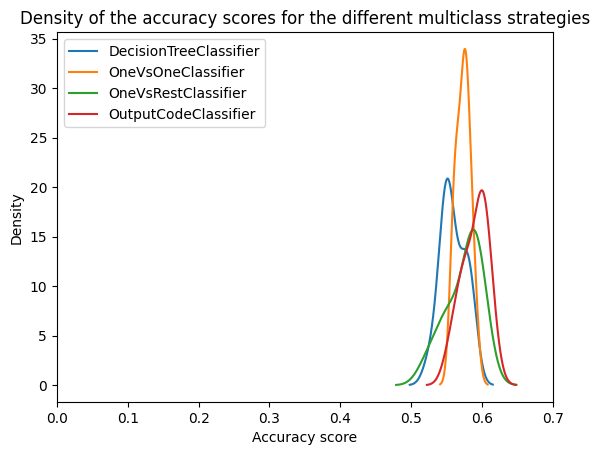

In [8]:
from sklearn.model_selection import GridSearchCV
# DecisionTreeClassifier()
param_grid = {"max_depth": [3, 5, 8,10],"criterion":["gini","entropy"],}
tree_optimized = GridSearchCV(tree, param_grid=param_grid, cv=3)
ovo_tree = OneVsOneClassifier(tree_optimized)
ovr_tree = OneVsRestClassifier(tree_optimized)
ecoc = OutputCodeClassifier(tree_optimized, code_size=2)

cv_results_tree = cross_validate(tree_optimized, X, y, cv=cv, n_jobs=2, verbose = 1)
cv_results_ovo = cross_validate(ovo_tree, X, y, cv=cv, n_jobs=2, verbose = 1)
cv_results_ovr = cross_validate(ovr_tree, X, y, cv=cv, n_jobs=2)
cv_results_ecoc = cross_validate(ecoc, X, y, cv=cv, n_jobs=2, verbose = 1)

scores = pd.DataFrame(
    {
        "DecisionTreeClassifier": cv_results_tree["test_score"],
        "OneVsOneClassifier": cv_results_ovo["test_score"],
        "OneVsRestClassifier": cv_results_ovr["test_score"],
        "OutputCodeClassifier": cv_results_ecoc["test_score"],
    }
)
ax = scores.plot.kde(legend=True)
ax.set_xlabel("Accuracy score")
ax.set_xlim([0, 0.7])
_ = ax.set_title(
    "Density of the accuracy scores for the different multiclass strategies"
)

plt.show()

We can see that once the hyperparameters are optimized, all multiclass
strategies have similar performance as discussed in [3]_.

## Conclusion

We can get some intuition behind those results.

First, the reason for which one-vs-one and error-correcting output code are
outperforming the tree when the hyperparameters are not optimized relies on
fact that they ensemble a larger number of classifiers. The ensembling
improves the generalization performance. This is a bit similar why a bagging
classifier generally performs better than a single decision tree if no care
is taken to optimize the hyperparameters.

Then, we see the importance of optimizing the hyperparameters. Indeed, it
should be regularly explored when developing predictive models even if
techniques such as ensembling help at reducing this impact.

Finally, it is important to recall that the estimators in scikit-learn
are developed with a specific strategy to handle multiclass classification
out of the box. So for these estimators, it means that there is no need to
use different strategies. These strategies are mainly useful for third-party
estimators supporting only binary classification. In all cases, we also show
that the hyperparameters should be optimized.

## References

  .. [1] https://archive.ics.uci.edu/ml/datasets/Yeast

  .. [2] ["Reducing multiclass to binary: A unifying approach for margin classifiers."
     Allwein, Erin L., Robert E. Schapire, and Yoram Singer.
     Journal of machine learning research 1
     Dec (2000): 113-141.](https://www.jmlr.org/papers/volume1/allwein00a/allwein00a.pdf).

  .. [3] ["In defense of one-vs-all classification."
     Journal of Machine Learning Research 5
     Jan (2004): 101-141.](https://www.jmlr.org/papers/volume5/rifkin04a/rifkin04a.pdf).

